In [4]:
# ! conda install -c conda-forge ta --yes

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\George\anaconda3

  added / updated specs:
    - ta


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-22.11.1              |   py39hcbf5309_1         908 KB  conda-forge
    python_abi-3.9             |           2_cp39           4 KB  conda-forge
    ruamel.yaml-0.17.21        |   py39hb82d6ee_1         169 KB  conda-forge
    ruamel.yaml.clib-0.2.6     |   py39h2bbff1b_1         101 KB
    ta-0.10.2                  |     pyhd8ed1ab_0         1.6 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.7 MB

The following NEW packages will be INSTALLED:

  python_abi         conda-forge/win-64::python_abi-3.9-2_cp39 None
  ruamel.yaml        conda-forge/win-64::ruamel.yaml-0.17.21-py39hb82d6ee_1 None
  ru



==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c defaults conda




==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c defaults conda




Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\George\anaconda3

  added / updated specs:
    - ta


The following NEW packages will be INSTALLED:

  python_abi         conda-forge/win-64::python_abi-3.9-2_cp39 None
  ruamel.yaml        conda-forge/win-64::ruamel.yaml-0.17.21-py39hb82d6ee_1 None
  ruamel.yaml.clib   pkgs/main/win-64::ruamel.yaml.clib-0.2.6-py39h2bbff1b_1 None
  ta                 conda-forge/noarch::ta-0.10.2-pyhd8ed1ab_0 None

The following packages will be UPDATED:

  conda              pkgs/main::conda-22.9.0-py39haa95532_0 --> conda-forge::conda-22.11.1-py39hcbf5309_1 None


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done
Retrieving notices: ...working... done
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\George\anaconda3

  added / updated specs:
    - ta


The following NEW packages will be IN



==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c defaults conda




In [48]:
import websocket
import requests
import json
import pandas as pd
import ta
import matplotlib.pyplot as plt
import math
import pytz
import datetime as dt
import numpy as np

In [99]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
rate = 30
interval = '15m'
limit = 200

In [140]:
data = json.dumps({'method':'SUBSCRIBE','params':[symbol + '@kline_' + interval],'id':1})
df = pd.DataFrame()

In [141]:
def get_historical(symbol, interval, limit):
    url = "https://api.binance.com/api/v3/klines"
    params = {"symbol": symbol_C,
              "interval": interval,
              "limit": limit}
    response = requests.get(url, params=params).json()
    df = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                           "Volume", "Close_Time", "Quote asset volume",
                                           "Number of trades", "Taker buy base asset volume",
                                           "Taker buy quote asset volume", "Ignore"])
    df = df[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    df = df.astype(convert_dict)
    return df

In [142]:
df = get_historical(symbol, interval, limit)
df['Close_Time'] = pd.to_datetime(df['Close_Time'], unit = 'ms')

# def adjust_utc_time(utc_time):
#     utc_time = dt.datetime.strptime(utc_time, '%Y-%m-%d %H:%M:%S')
#     adjusted_time = utc_time + dt.timedelta(hours=timezone)
#     return adjusted_time.strftime('%Y-%m-%d %H:%M:%S')

df['Close_Time'] = df['Close_Time'] + pd.Timedelta(hours=timezone)

df['Closed'] = True

print(df)

                       Close_Time     Open    Close     High      Low  \
0   2023-02-12 13:59:59.999000064  1533.08  1533.71  1533.91  1532.52   
1   2023-02-12 14:14:59.999000064  1533.72  1533.51  1534.56  1533.51   
2   2023-02-12 14:29:59.999000064  1533.51  1533.46  1534.18  1532.79   
3   2023-02-12 14:44:59.999000064  1533.45  1533.47  1534.01  1531.81   
4   2023-02-12 14:59:59.999000064  1533.48  1533.20  1533.48  1531.50   
..                            ...      ...      ...      ...      ...   
195 2023-02-14 14:44:59.999000064  1503.97  1502.17  1504.00  1501.97   
196 2023-02-14 14:59:59.999000064  1502.17  1503.64  1504.91  1501.98   
197 2023-02-14 15:14:59.999000064  1503.65  1503.26  1504.02  1503.04   
198 2023-02-14 15:29:59.999000064  1503.26  1504.75  1505.26  1502.71   
199 2023-02-14 15:44:59.999000064  1504.74  1506.40  1507.38  1503.93   

        Volume  Closed  
0    1011.2636    True  
1    1042.1335    True  
2     947.9434    True  
3    1050.3091    True 

In [62]:
def on_open(ws):
    ws.send(data)

def on_message(ws, message):
    global df, rate, limit
    out = json.loads(message)    
    out = pd.DataFrame({'Close_Time':pd.to_datetime(out['E']),
                        'Open':float(out['k']['o']),
                        'Close':float(out['k']['c']),
                        'High':float(out['k']['h']),
                        'Low':float(out['k']['l']),
                        'Volume':float(out['k']['v']),
                        'Closed':bool(out['k']['x']),
                        })


    # out['Sma'] = sma.tail(1)[0]
    # out['Bb_U'] = bband_up.tail(1)[0]
    # out['Bb_D'] = bband_down.tail(1)[0]
    df = pd.concat([df,out], axis = 0)


    
    print(df)
    # df = df.tail(5)
    # df.drop(df[df['closed'] == False].index, axis=0, inplace=True)



In [11]:
ws = websocket.WebSocketApp(endpoint, on_message = on_message, on_open = on_open)
ws.run_forever()

                  Open    Close     High      Low     Volume  Closed
1676020499999  1550.83  1549.30  1552.53  1549.12  1729.5147    True
1676021399999  1549.29  1552.03  1552.10  1547.37  2316.3675    True
1676022299999  1552.02  1549.51  1552.19  1548.19  1683.2590    True
1676023199999  1549.52  1545.77  1551.00  1545.36  2139.1519    True
1676024099999  1545.76  1546.19  1546.82  1544.21  1853.6841    True
...                ...      ...      ...      ...        ...     ...
1676097899999  1517.86  1518.10  1519.26  1516.83  1264.1352    True
1676098799999  1518.10  1518.71  1518.71  1517.16  1551.6688    True
1676099699999  1518.70  1519.30  1520.45  1518.20  1871.2246    True
1676100599999  1519.31  1518.63  1519.52  1516.40  1255.4157    True
1676100476154  1519.31  1517.71  1519.52  1516.40  1346.0511   False

[91 rows x 6 columns]
                  Open    Close     High      Low     Volume  Closed
1676020499999  1550.83  1549.30  1552.53  1549.12  1729.5147    True
16760213999

False

In [143]:
def indicators(df):
#     sma
    sma_int = 30
    df['sma'] = ta.trend.sma_indicator(df.Close, window=sma_int)
#     bband
    bb_int = 30
    bb_dev = 2
    bb = ta.volatility.BollingerBands(df['Close'], window=bb_int, window_dev=bb_dev)
    df['bb_u'] = bb.bollinger_hband()
    df['bb_m'] = bb.bollinger_mavg()
    df['bb_l'] = bb.bollinger_lband()
#     rsi
    rsi_int = 14
    df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()
#     df.dropna(inplace=True)
    return df

In [144]:
indicators(df)

,Close_Time,Open,Close,High,Low,Volume,Closed,sma,bb_u,bb_m,bb_l,rsi
0,2023-02-12 13:59:59.999000064,1533.08,1533.71,1533.91,1532.52,1011.2636,True,NaN,NaN,NaN,NaN,NaN
1,2023-02-12 14:14:59.999000064,1533.72,1533.51,1534.56,1533.51,1042.1335,True,NaN,NaN,NaN,NaN,NaN
2,2023-02-12 14:29:59.999000064,1533.51,1533.46,1534.18,1532.79,947.9434,True,NaN,NaN,NaN,NaN,NaN
3,2023-02-12 14:44:59.999000064,1533.45,1533.47,1534.01,1531.81,1050.3091,True,NaN,NaN,NaN,NaN,NaN
4,2023-02-12 14:59:59.999000064,1533.48,1533.20,1533.48,1531.50,1662.3264,True,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
195,2023-02-14 14:44:59.999000064,1503.97,1502.17,1504.00,1501.97,2889.0763,True,1501.099000,1506.942776,1501.099000,1495.255224,55.935951
196,2023-02-14 14:59:59.999000064,1502.17,1503.64,1504.91,1501.98,2595.5845,True,1500.963000,1506.356663,1500.963000,1495.569337,58.524430
197,2023-02-14 15:14:59.999000064,1503.65,1503.26,1504.02,1503.04,2520.1279,True,1500.804333,1505.605816,1500.804333,1496.002851,57.582749
198,2023-02-14 15:29:59.999000064,1503.26,1504.75,1505.26,1502.71,1804.7731,True,1500.788000,1505.532005,1500.788000,1496.043995,60.281406


In [145]:
def conditions(df):
    # 進場條件
    # （收盤－低點）大於（開盤－收盤）
    # 收盤 小於 布林下
    # 紅Ｋ

    for index, row in df.iterrows():
        df['c1'] = df['Close'] - df['Low'] > df['Open'] - df['Close']
        df['c2'] = df['Close'] < df['bb_l']
        df['c3'] = df['Close'] < df['Open']

    # 條件達成
    df['signal'] = False
    df.loc[df.c1 & df.c2 & df.c3, 'signal'] = True

    df = df.reset_index(drop=True)

    # 下根進場
    df['openbuy'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'openbuy'] = True
    
    return df

In [150]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,Closed,sma,bb_u,bb_m,bb_l,rsi,c1,c2,c3,signal,openbuy
0,2023-02-12 13:59:59.999000064,1533.08,1533.71,1533.91,1532.52,1011.2636,True,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False
1,2023-02-12 14:14:59.999000064,1533.72,1533.51,1534.56,1533.51,1042.1335,True,NaN,NaN,NaN,NaN,NaN,False,False,True,False,False
2,2023-02-12 14:29:59.999000064,1533.51,1533.46,1534.18,1532.79,947.9434,True,NaN,NaN,NaN,NaN,NaN,True,False,True,False,False
3,2023-02-12 14:44:59.999000064,1533.45,1533.47,1534.01,1531.81,1050.3091,True,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False
4,2023-02-12 14:59:59.999000064,1533.48,1533.20,1533.48,1531.50,1662.3264,True,NaN,NaN,NaN,NaN,NaN,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2023-02-14 14:44:59.999000064,1503.97,1502.17,1504.00,1501.97,2889.0763,True,1501.099000,1506.942776,1501.099000,1495.255224,55.935951,False,False,True,False,False
196,2023-02-14 14:59:59.999000064,1502.17,1503.64,1504.91,1501.98,2595.5845,True,1500.963000,1506.356663,1500.963000,1495.569337,58.524430,True,False,False,False,False
197,2023-02-14 15:14:59.999000064,1503.65,1503.26,1504.02,1503.04,2520.1279,True,1500.804333,1505.605816,1500.804333,1496.002851,57.582749,False,False,True,False,False
198,2023-02-14 15:29:59.999000064,1503.26,1504.75,1505.26,1502.71,1804.7731,True,1500.788000,1505.532005,1500.788000,1496.043995,60.281406,True,False,False,False,False


In [153]:
buydf = conditions(df)

# 進出場
in_position = False
stop_loss = np.nan
for index, row in buydf.iterrows():

    if index == 0:
        continue
        
        # set entry price (前一根k線收盤價進場)
        # set stop loss (前一根k線低點停損)
        # 進場
    elif buydf.at[index, 'openbuy'] == True:
        close_val = buydf['Close']
        low_val = buydf['Low']
        buydf.at[index, 'entry_p'] = close_val.shift(1).at[index]
        buydf.at[index, 'stop_loss'] = low_val.shift(1).at[index]
        buydf.at[index, 'position'] = 'Buy'
        in_position = True
        stop_loss = low_val.shift(1).at[index]
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position == True and buydf.at[index, 'Close'] < stop_loss:
        buydf.at[index, 'in_position'] = in_position
        buydf.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan

    # set take profit （高點碰到上布林，即刻出場）
    elif buydf.at[index, 'High'] >= buydf.at[index, 'bb_u'] and in_position == True:

        buydf.at[index, 'position'] = 'Sell'
        in_position = False
        stop_loss = np.nan


buydf = buydf[(buydf['openbuy'] == True) |
              (buydf['signal'] == True) | 
              (buydf['position'] == 'Buy') |
              (buydf['position'] == 'Sell') |
              (buydf['position'] == 'Stop')]


print(buydf)
# df.to_csv('buydf.csv')


                       Close_Time     Open    Close     High      Low  \
31  2023-02-12 21:44:59.999000064  1524.48  1524.19  1525.67  1521.43   
32  2023-02-12 21:59:59.999000064  1524.19  1526.26  1527.00  1524.18   
38  2023-02-12 23:29:59.999000064  1535.46  1532.86  1541.00  1532.86   
65  2023-02-13 06:14:59.999000064  1511.22  1502.65  1515.10  1493.08   
66  2023-02-13 06:29:59.999000064  1502.65  1510.03  1512.15  1498.44   
102 2023-02-13 15:29:59.999000064  1520.74  1523.90  1526.10  1520.43   
113 2023-02-13 18:14:59.999000064  1482.36  1481.50  1487.97  1479.69   
114 2023-02-13 18:29:59.999000064  1481.50  1474.80  1482.76  1466.00   
115 2023-02-13 18:44:59.999000064  1474.80  1480.80  1480.90  1474.36   
148 2023-02-14 02:59:59.999000064  1484.71  1488.96  1493.91  1484.56   

         Volume  Closed          sma         bb_u         bb_m         bb_l  \
31    3221.2165    True  1532.373667  1539.061988  1532.373667  1525.685346   
32    1925.4713    True  1532.133667  

In [ ]:
# 部位回測
posdf = buydf
posdf = posdf.reset_index(drop = True)
posdf = posdf[(posdf['position'] == 'Buy') |
              (posdf['position'] == 'Sell') |
              (posdf['position'] == 'Stop')]


pos_size = 1

col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'sma', 'bb_u', 'bb_l', 'rsi', 'position','entry_p', 'stop_loss']
pos = posdf[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：打到上布林
        if pos.at[index, 'position'] == 'Sell':
            pos.at[index, 'exit_p'] = pos.at[index, 'bb_u']

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
                break

        # 計算每次出場部位大小
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Buy':
                current_pos += pos.at[i, 'size']
                if i == index - 1:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)

    
        
print(pos)

ttl_profit = -pos.amt.sum()

ttl_entry = 0
for i in range(len(pos) - 1):
    if pos.loc[i, 'position'] == 'Buy':
        ttl_entry += pos.loc[i, 'entry_p'] * pos.loc[i, 'size']

profit_per = "{:.2f}%".format(ttl_profit / ttl_entry)
        
print(ttl_profit, profit_per)


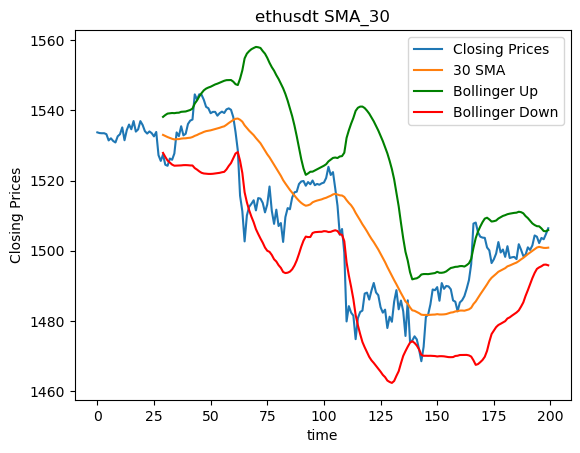

In [184]:
plt.title(symbol + ' SMA_' + str(rate))
plt.xlabel('time')
plt.ylabel('Closing Prices')
plt.plot(df.Close, label='Closing Prices')
plt.plot(df.sma, label= str(rate) + ' SMA')
plt.plot(df.bb_u, label='Bollinger Up', c='g')
plt.plot(df.bb_l, label='Bollinger Down', c='r')
plt.legend()
plt.show()